# Wind Turbine Power Production
###  Project assessment
#### [Machine Learning and Statistics Module GMIT 2020 ]

---

<img align="left" width="300" src="https://image.flaticon.com/icons/png/512/1778/1778210.png">
<br>

<br>

Lecturer: *Ian McLoughlin (https://github.com/ianmcloughlin)*

Completed by: *Olga Rozhdestvina (G00387844@gmit.ie)*

---

## Table of Contents

* [Overview](#overview)
* [General Setup](#setup)
* [Raw Data](#loading_data)
* [Data Pre-processing](#preproccesing)
    * [Outliners](#outliners)
    * [Creating Arrays for the Speed and the Power Variable](#arrays)
    * [Creating the Training and Test Datasets](#split)
* [Build, Predict, and Evaluate the Models](#models)
    * [Linear Regression with Polynomial Features](#lr)
    * [](#)
    * [Neural Networks](#nn)

<br>

### Overview. <a name="overview"></a>
___

<br>

### General Setup. <a name="setup"></a>
___

In [1]:
# Neural networks.
import tensorflow.keras as kr

# Preprocessing
from sklearn.model_selection import train_test_split as tts
import sklearn.linear_model as md
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Numerical arrays.
import numpy as np

# Data frames.
import pandas as pd

# Plotting.
import matplotlib.pyplot as plt
# Another package for plotting.
import seaborn as sns

%matplotlib inline

In [2]:
# Theme for plots.
sns.set_theme(palette="Set2", context="paper", font_scale=1.5, )

# Plot size.
plt.rcParams['figure.figsize'] = [14, 8]

<br>

### Raw Data. <a name="loading_data"></a>
___

> [1] [Adjusting Size of Seaborn Plot](https://stackoverflow.com/questions/51502927/adjusting-size-of-seaborn-plot)

In [3]:
# Load the iris data set from a URL.
df = pd.read_csv("powerproduction.csv")

# Display the data frame.
df

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0
...,...,...
495,24.775,0.0
496,24.850,0.0
497,24.875,0.0
498,24.950,0.0


The data set has two numerical variables **speed** and **power**. They are both represented by real numbers: speed to 3 decimal points and power to one decimal point. Let's check if the data set has any empty values. 

In [4]:
# Check for empty values.
df.isnull().values.any()

False

In [5]:
# Stats.
df.describe()

,speed,power
count,500.000000,500.000000
mean,12.590398,48.014584
std,7.224991,41.614572
min,0.000000,0.000000
25%,6.324750,5.288000
50%,12.550500,41.645500
75%,18.775250,93.537000
max,25.000000,113.556000


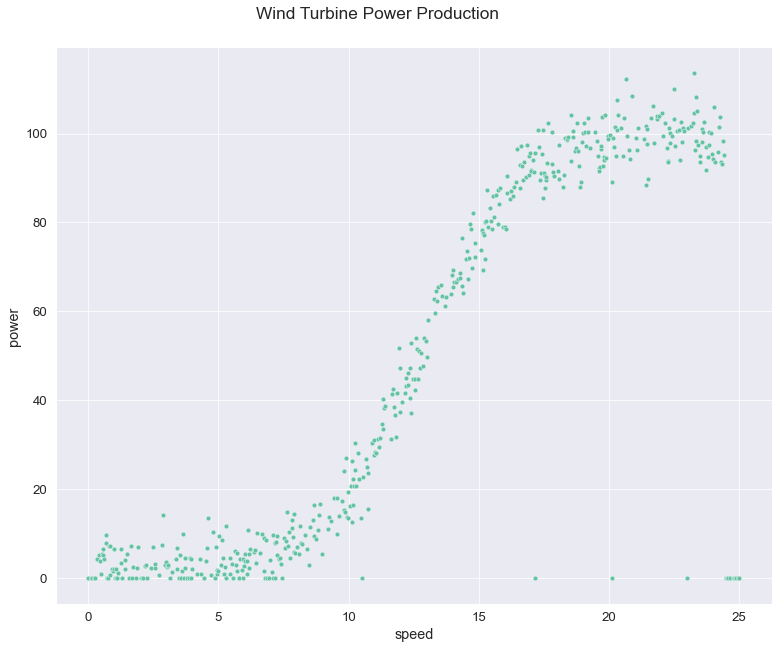

In [6]:
# Plot data.
sns.relplot(data=df, x="speed", y="power")

# Change plot size.
fig = plt.gcf()
fig.set_size_inches(12, 9)
fig.suptitle("Wind Turbine Power Production", y=1.02)

# Show the plot.
plt.show()

The above plot shows that the data follows a polynominal regression. The relationship between Power and Speed predominantly take "S"-shape. The power rises dramatically with speed over about 8 m/s and slows when the speed reaches about 17 m/s.

Additionally, we can see some outliners where the speed is above 10 m/s, however, the power is still 0.

<br>

###  Data Pre-processing. <a name="preproccesing"></a>
___

#### 1. Outliners.  <a name="outliners"></a>
The first step is to remove those outliners from our data set. [2] [3]

> [2] [Non-Linear Regression Trees with scikit-learn](https://www.pluralsight.com/guides/non-linear-regression-trees-scikit-learn)
<br>
[3] [Delete rows based on multiple conditions; including other column conditionals](https://stackoverflow.com/questions/31997992/delete-rows-based-on-multiple-conditions-including-other-column-conditionals)

In [7]:
# Remove outliners.
df_new = df.drop(df[(df.power == 0) & (df.speed > 5)].index)

# Display cleaned data set.
df_new

,speed,power
0,0.000,0.000
1,0.125,0.000
2,0.150,0.000
3,0.225,0.000
4,0.275,0.000
...,...,...
485,24.249,103.700
486,24.299,93.694
487,24.349,93.078
488,24.374,98.223


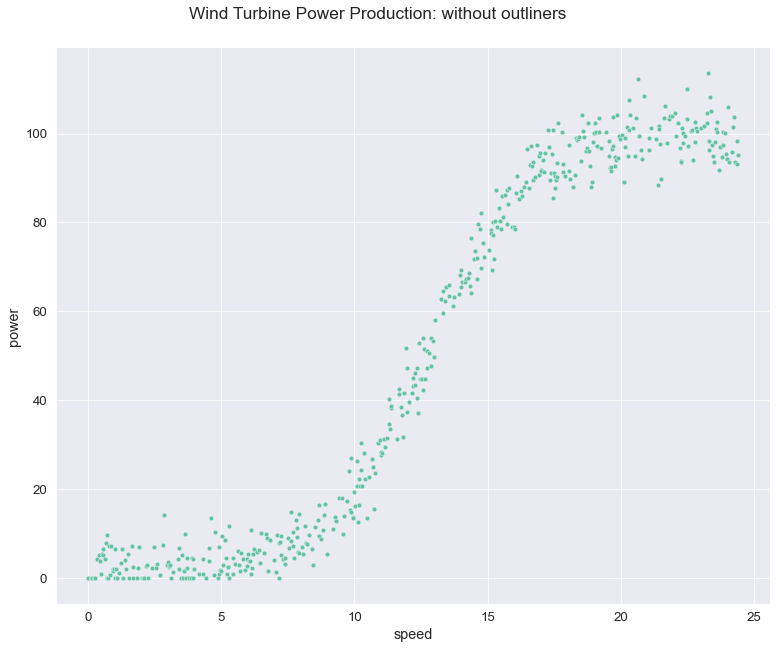

In [8]:
# Plot data.
sns.relplot(data=df_new, x="speed", y="power")

# Change plot size.
fig = plt.gcf()
fig.set_size_inches(12, 9)
fig.suptitle("Wind Turbine Power Production: without outliners", y=1.02)

# Show the plot.
plt.show()

<br>

#### 2. Creating Arrays for the Speed and the Power Variable.  <a name="arrays"></a>

Now the data set should be separated for speed and power values. 

In [9]:
# Separate speed and power.
speed = df_new.iloc[:, 0].values
power = df_new.iloc[:, 1].values

# Convert them into a numpy array.
X = np.array(speed).reshape(-1,1)
y = np.array(power)

<br>

#### 3. Creating the Training and Test Datasets.  <a name="split"></a>

We will build our model on the training set and evaluate its performance on the test set. 

In [10]:
# Split data on training and test (add random state so the outputs are the same after each execution).
speed_train, speed_test, power_train, power_test = tts(X, y, test_size=0.3, random_state=1)

In [11]:
print(f"Training set: {speed_train.shape}, {power_train.shape}")
print(f"Test set: {speed_test.shape}, {power_test.shape}")

Training set: (333, 1), (333,)
Test set: (144, 1), (144,)


<br>

### Build, Predict, and Evaluate the Models. <a name="models"></a>

<br>

#### Linear Regression with Polynomial Features.  <a name="lr"></a>
___

<br>

Since we have Polynomial regression we can apply the first step is to apply polynomial features. In oder to do so we need first find the best fitting degree. [4]

>[4] [Polynomial interpolation](https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html#sphx-glr-auto-examples-linear-model-plot-polynomial-interpolation-py)

In [12]:
# Find the best degree (over 6 causes overfitting of data).
for degree in range(1,6):
    # Create a pipeline.
    pipeline = make_pipeline(PolynomialFeatures(degree), md.LinearRegression())
    # Fit it to the original data.
    pipeline.fit(X, y)
    print(f'{degree}: {pipeline.score(X,y)}')

1: 0.9033294610539289
2: 0.9051963072726177
3: 0.9785340997342342
4: 0.9798979555477244
5: 0.9883718320837762


<br>
The results found that the degree 5 scores the best. Now we can create a model and fit it to our data. Additionally, we should calculate Mean Squared Error to evaluate the model. [5]

>[5] [Model evaluation: quantifying the quality of predictions](https://scikit-learn.org/0.15/modules/model_evaluation.html)

In [13]:
# Create a pipeline with 5 degrees.
pipeline = make_pipeline(PolynomialFeatures(5), md.LinearRegression())

# Fit the model to the original data.
pipeline.fit(X, y)

# Predict y.
y_train_pred = pipeline.predict(X)

# Calculate mse.
print("MSE: ", np.sqrt(mean_squared_error(y,y_train_pred)))
print("Score:", r2_score(y,y_train_pred))

MSE:  4.439726730493947
Score: 0.9883718320837762


<br> 

Let's see how the model fits our original data set on the plot.

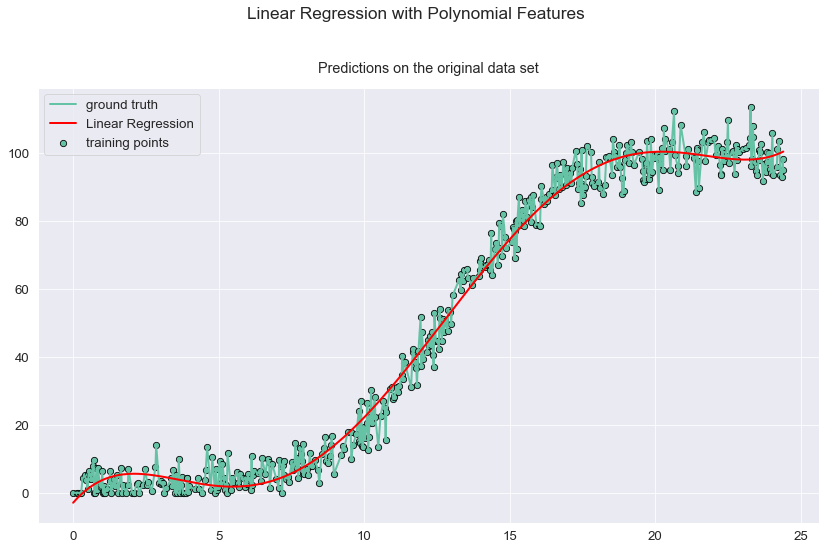

In [14]:
# Create a figure, axis and titles.
fig, ax = plt.subplots()
fig.suptitle("Linear Regression with Polynomial Features", y=1.02)
ax.set_title("Predictions on the original data set",y=1.02)

# Plot training points and line connecting them.
ax.plot(X, y, linewidth=2, label="ground truth")
ax.scatter(X, y, s=40, edgecolors="black", label="training points")

# Plot predictions.
ax.plot(X, y_train_pred, c="red", linewidth=2, label="Linear Regression")
    
# Show legend.
plt.legend(loc='upper left')

# Show the plot.
plt.show()

<br>

Now that we have the model created, we can fit it on the training data, make predictions on the test data and plot them. 

In [15]:
# Fit the model on the training data.
pipeline.fit(speed_train, power_train)

# Predict power from test speed.
y_test_pred = pipeline.predict(speed_test)

# Calculate a score and mse.
print("MSE: ", np.sqrt(mean_squared_error(power_test,y_test_pred)))
print("Score:", r2_score(power_test,y_test_pred))

MSE:  4.429196503744085
Score: 0.988392880162633


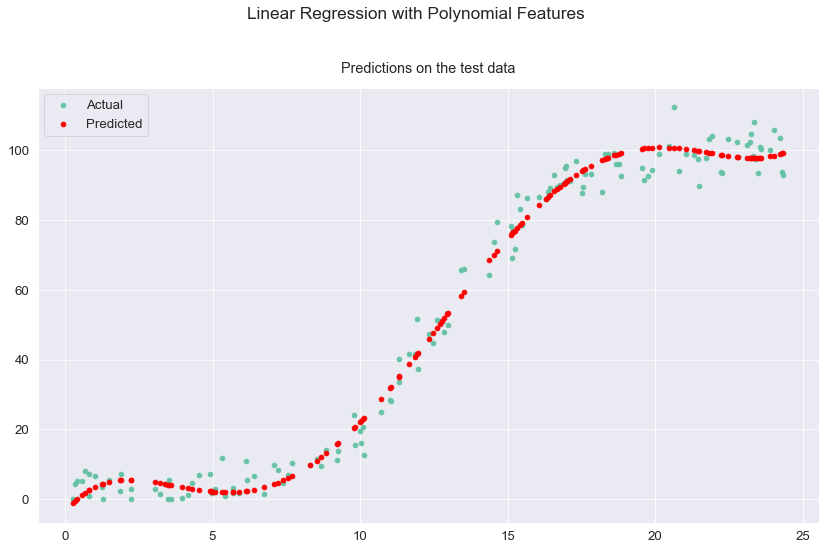

In [16]:
# Create a figure, axis and titles.
fig, ax = plt.subplots()
fig.suptitle("Linear Regression with Polynomial Features", y=1.02)
ax.set_title("Predictions on the test data",y=1.02)

# Plot actual test data and predictions.
ax.scatter(speed_test, power_test, label="Actual")
ax.scatter(speed_test, y_test_pred, c="red", label="Predicted")

# Show legend.
plt.legend(loc='upper left')

# Show the plot.
plt.show()

<br>

#### .  <a name=""></a>
___


<br>

#### Neural Networks.  <a name="nn"></a>
___


In [17]:
# Train a different model.
model = kr.models.Sequential()
model.add(kr.layers.Dense(50, input_shape=(1,), activation='sigmoid', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
model.add(kr.layers.Dense(1, activation='linear', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
model.compile("adam", loss='mse')

In [18]:
# Train the neural network on our training data.
model.fit(speed_train, power_train, epochs=400)

Epoch 1/400
11/11 [==============================] - 1s 4ms/step - loss: 4045.1720
Epoch 2/400
11/11 [==============================] - 0s 4ms/step - loss: 3956.1595
Epoch 3/400
11/11 [==============================] - 0s 4ms/step - loss: 3630.5924
Epoch 4/400
11/11 [==============================] - 0s 4ms/step - loss: 3560.6526
Epoch 5/400
11/11 [==============================] - 0s 5ms/step - loss: 3759.7713
Epoch 6/400
11/11 [==============================] - 0s 4ms/step - loss: 3810.7078
Epoch 7/400
11/11 [==============================] - 0s 4ms/step - loss: 3584.9890
Epoch 8/400
11/11 [==============================] - 0s 4ms/step - loss: 3472.1196
Epoch 9/400
11/11 [==============================] - 0s 4ms/step - loss: 3879.6446
Epoch 10/400
11/11 [==============================] - 0s 4ms/step - loss: 3705.3966
Epoch 11/400
11/11 [==============================] - 0s 5ms/step - loss: 3497.0816
Epoch 12/400
11/11 [==============================] - 0s 4ms/step - loss: 3243.6084
E

11/11 [==============================] - 0s 5ms/step - loss: 1226.6031
Epoch 99/400
11/11 [==============================] - 0s 5ms/step - loss: 1339.7039
Epoch 100/400
11/11 [==============================] - 0s 4ms/step - loss: 1223.8701
Epoch 101/400
11/11 [==============================] - 0s 4ms/step - loss: 1262.4811
Epoch 102/400
11/11 [==============================] - 0s 4ms/step - loss: 1245.1590
Epoch 103/400
11/11 [==============================] - 0s 4ms/step - loss: 1246.0394
Epoch 104/400
11/11 [==============================] - 0s 4ms/step - loss: 1228.8859
Epoch 105/400
11/11 [==============================] - 0s 4ms/step - loss: 1240.2466
Epoch 106/400
11/11 [==============================] - 0s 5ms/step - loss: 1195.1209
Epoch 107/400
11/11 [==============================] - 0s 6ms/step - loss: 1218.6230
Epoch 108/400
11/11 [==============================] - 0s 5ms/step - loss: 1253.9159
Epoch 109/400
11/11 [==============================] - 0s 5ms/step - loss: 1167.

11/11 [==============================] - 0s 4ms/step - loss: 468.7696
Epoch 195/400
11/11 [==============================] - 0s 4ms/step - loss: 467.5041
Epoch 196/400
11/11 [==============================] - 0s 3ms/step - loss: 523.4365
Epoch 197/400
11/11 [==============================] - 0s 4ms/step - loss: 452.7863
Epoch 198/400
11/11 [==============================] - 0s 3ms/step - loss: 465.5930
Epoch 199/400
11/11 [==============================] - 0s 4ms/step - loss: 469.9060
Epoch 200/400
11/11 [==============================] - 0s 4ms/step - loss: 469.0588
Epoch 201/400
11/11 [==============================] - 0s 4ms/step - loss: 454.6466
Epoch 202/400
11/11 [==============================] - 0s 4ms/step - loss: 442.5959
Epoch 203/400
11/11 [==============================] - 0s 4ms/step - loss: 418.7203
Epoch 204/400
11/11 [==============================] - 0s 4ms/step - loss: 426.1823
Epoch 205/400
11/11 [==============================] - 0s 4ms/step - loss: 436.6956
Epoch 

11/11 [==============================] - 0s 4ms/step - loss: 172.0430
Epoch 292/400
11/11 [==============================] - 0s 4ms/step - loss: 170.1090
Epoch 293/400
11/11 [==============================] - 0s 4ms/step - loss: 171.4552
Epoch 294/400
11/11 [==============================] - 0s 4ms/step - loss: 169.7810
Epoch 295/400
11/11 [==============================] - 0s 4ms/step - loss: 159.7082
Epoch 296/400
11/11 [==============================] - 0s 3ms/step - loss: 158.2722
Epoch 297/400
11/11 [==============================] - 0s 4ms/step - loss: 155.8071
Epoch 298/400
11/11 [==============================] - 0s 4ms/step - loss: 158.8635
Epoch 299/400
11/11 [==============================] - 0s 5ms/step - loss: 160.4820
Epoch 300/400
11/11 [==============================] - 0s 5ms/step - loss: 170.5069
Epoch 301/400
11/11 [==============================] - 0s 4ms/step - loss: 162.6460
Epoch 302/400
11/11 [==============================] - 0s 4ms/step - loss: 149.1573
Epoch 

11/11 [==============================] - 0s 6ms/step - loss: 80.3340
Epoch 389/400
11/11 [==============================] - 0s 4ms/step - loss: 84.8170
Epoch 390/400
11/11 [==============================] - 0s 4ms/step - loss: 85.0249
Epoch 391/400
11/11 [==============================] - 0s 4ms/step - loss: 87.2669
Epoch 392/400
11/11 [==============================] - 0s 4ms/step - loss: 81.9438
Epoch 393/400
11/11 [==============================] - 0s 4ms/step - loss: 75.8042
Epoch 394/400
11/11 [==============================] - 0s 4ms/step - loss: 79.0619
Epoch 395/400
11/11 [==============================] - 0s 4ms/step - loss: 82.6907
Epoch 396/400
11/11 [==============================] - 0s 4ms/step - loss: 78.4559
Epoch 397/400
11/11 [==============================] - 0s 4ms/step - loss: 73.2251
Epoch 398/400
11/11 [==============================] - 0s 4ms/step - loss: 78.2920
Epoch 399/400
11/11 [==============================] - 0s 4ms/step - loss: 80.4747
Epoch 400/400
11/1

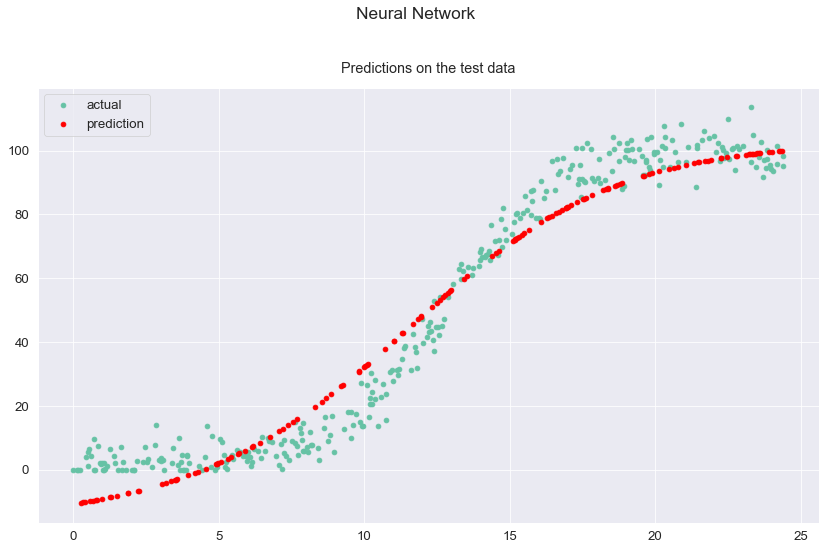

In [19]:
# Create a figure, axis and titles.
fig, ax = plt.subplots()
fig.suptitle("Neural Network", y=1.02)
ax.set_title("Predictions on the test data",y=1.02)

# Plot actual test data and predictions.
ax.scatter(speed_train, power_train, label='actual')
ax.scatter(speed_test, model.predict(speed_test), label='prediction', c="r")

# Show the legend.
plt.legend()

# Show the plot.
plt.show()